# Early Model Testing

In [330]:
%matplotlib inline
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np
import os
import time

### Load dataset

In [190]:
input_file_name = "lotOfFeatures.csv"
input_file_path = os.path.join(os.path.join(os.getcwd(), "data"), input_file_name)

original_data = pd.read_csv(input_file_path, index_col=0, parse_dates=True)
originalSize = original_data.shape[1]
original_data.head()
original_data.shape

(140350, 445)

## Excluding Testing Set

Spliting the dataset into three parts: training, testing and evaluation (last 10 percent).

In [191]:
start_time = '2012-02-01 00:00:00'
#start_time = '2014-02-01 00:00:00'
splitting_point = int(0.9 * original_data.shape[0])
splitting_time = original_data.iloc[[splitting_point]].index.to_pydatetime()[0]
#data = original_data[:splitting_time]
data = original_data[start_time:]

# Define Machine Learning Models and Data Sets

In [192]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

## Creating Feature Sets

In [193]:
measurements_cols = ['measurement', 'measurement_roll_mean_1h', 'measurement_roll_mean_6h', 'measurement_roll_mean_d', 
                     'measurement_roll_mean_w', 'measurement_roll_mean_m', 'measurement_roll_min2_d',
                     'measurement_roll_min2_w', 'measurement_roll_max2_d', 'measurement_roll_max2_w',
                     'measurement_roll_var_6h', 'measurement_roll_var_d', 'measurement_roll_var_w']

wetaher_current_cols =  ['p', 't2m_termin', 'rh_termin', 'padavine', 'veter_hitrost', 'veter_vek_smer', 'energija_gl',
 'energija_di', 'p_roll_mean_1h', 'p_roll_mean_6h', 'p_roll_mean_d', 'p_roll_mean_w', 'p_roll_mean_m', 'p_roll_var_1h',
 'p_roll_var_d', 't2m_termin_roll_mean_1h', 't2m_termin_roll_mean_6h', 't2m_termin_roll_mean_d', 't2m_termin_roll_mean_w',
 't2m_termin_roll_mean_m', 't2m_termin_roll_min2_d', 't2m_termin_roll_min2_w', 't2m_termin_roll_max2_d',
 't2m_termin_roll_max2_w', 't2m_termin_roll_var_1h', 't2m_termin_roll_var_d', 'rh_termin_roll_mean_1h',
 'rh_termin_roll_mean_6h', 'rh_termin_roll_mean_d', 'rh_termin_roll_mean_w', 'rh_termin_roll_mean_m',
 'rh_termin_roll_min2_d', 'rh_termin_roll_min2_w', 'rh_termin_roll_max2_d', 'rh_termin_roll_max2_w',
 'rh_termin_roll_var_1h', 'rh_termin_roll_var_d', 'energija_gl_roll_mean_1h', 'energija_gl_roll_mean_6h',
 'energija_gl_roll_mean_d', 'energija_gl_roll_mean_w', 'energija_gl_roll_mean_m', 'energija_gl_roll_var_1h',
 'energija_gl_roll_var_d']

weather_forecasted_cols =  ['shifted_p', 'shifted_t2m_termin', 'shifted_rh_termin', 'shifted_padavine', 
                            'shifted_veter_hitrost', 'shifted_veter_vek_smer', 'shifted_energija_gl']

date_time_cols =  ['shifted_HourOfDay', 'shifted_DayOfWeek', 'shifted_Month', 'shifted_Weekday', 'shifted_Weekend', 
                   'shifted_Holiday', 'shifted_DayBeforeHoliday', 'shifted_DayAfterHodliay', 'shifted_BusinessDay', 
                   'shifted_BusinessDay_sum', 'shifted_Holiday_sum']

top20_cols = ['measurement_roll_mean_d', 'measurement_roll_mean_6h', 'shifted_HourOfDay', 'shifted_energija_gl', 
         'measurement_roll_mean_1h', 'measurement_roll_var_d', 'measurement', 'measurement_roll_var_6h',
         'energija_gl_roll_mean_6h', 'measurement_roll_max2_d', 'shifted_BusinessDay', 'measurement_roll_min2_d', 
         'energija_gl_roll_mean_1h', 'energija_gl', 'shifted_DayOfWeek', 'energija_di', 'shifted_t2m_termin', 
         'measurement_roll_mean_w', 't2m_termin_roll_mean_6h', 'measurement_roll_mean_m']

In [194]:
all_cols = measurements_cols + wetaher_current_cols + weather_forecasted_cols + date_time_cols 
m_wc_wf_cols = measurements_cols + wetaher_current_cols + weather_forecasted_cols
m_wc_dt_cols = measurements_cols + wetaher_current_cols + date_time_cols 
m_wf_dt_cols = measurements_cols + weather_forecasted_cols + date_time_cols 
m_dt_cols = measurements_cols + date_time_cols 
m_cols = measurements_cols
top20_cols = top20_cols

## Prediction Results

In [195]:
models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"}
          ]

data_sets = [{'name': "all_ftrs", 'cols': all_cols},
             {'name': "m_wc_wf_ftrs", 'cols': m_wc_wf_cols},
             {'name': "m_wc_dt_ftrs", 'cols': m_wc_dt_cols},
             {'name': "m_wf_dt_ftrs", 'cols': m_wf_dt_cols},
             {'name': "m_dt_ftrs", 'cols': m_dt_cols},
             {'name': "m_ftrs", 'cols': m_cols},
             {'name': "top_20_ftrs", 'cols': top20_cols}
             ]

error_metrics = [{'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score},
                 #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
                 {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
                 {'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error}
                ]

#validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['sensor', 'horizon', 'error metric']),
#                             columns=pd.MultiIndex.from_arrays([[],[]], names=['method', 'data set']))

validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

In [196]:
validation_df = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[],[]], names=['horizon', 'dataset', 'model']),
                             columns=pd.MultiIndex.from_arrays([[],[]], names=['sensor', 'error metric'])) 

def start_prediction_valuation(verbose=False):

    #sensor_list = list(data)[:30] # Sensor ids (30)
    sensor_list = ['id14061721', 'id14061674', 'id14061709']

    for sensor_name in sensor_list:
        print "Working with sensor: {}".format(sensor_name)

        # Create dataframe for specific sensor
        sensor_cols_to_drop = [col for col in list(data) if col.startswith('id') and not col.startswith(sensor_name)]
        sensor_data_cols = [col for col in list(data) if col not in sensor_cols_to_drop]
        sensor_data = data[sensor_data_cols]

        # Replace 'sensor id' column names with 'measurement'
        sensor_data.rename(columns=lambda col: col.replace(sensor_name, 'measurement') if sensor_name in col else col, inplace=True)

        for horizon in range (1,25):

            # Prepare columns to shift
            columnsToShift = list(sensor_data)
            shiftedColumns = ["shifted_" + col for col in columnsToShift]

            # Shift columns
            start = time.time() # Start measuring time
            sensor_data[shiftedColumns] = sensor_data[columnsToShift].shift(horizon, freq='H')
            sensor_data.dropna(inplace=True)
            runtime = time.time() - start # Calculate runtime

            # Split Training and Testing set
            training_data = sensor_data[:splitting_time]
            testing_data = sensor_data[splitting_time:]

            if verbose: print "\n\t-->Prediction horizont: {}h. Shifting runtime: {:.2f}s".format(horizon, runtime)

            for data_set in data_sets:            
                # Create training vectors
                X_train = training_data[data_set['cols']].values
                y_train = training_data[["shifted_measurement"]].values.ravel()

                # Create testing vectors
                X_test = testing_data[data_set['cols']].values
                y_test = testing_data[["shifted_measurement"]].values.ravel()

                if verbose: print "\n\t\t-->Dataset: {}. X_train: {}, y_train: {}".format(data_set['name'], X_train.shape, y_train.shape)

                for model in models: 
                    # Initializing model
                    mdl = eval(model['init'])

                    # Model leraning
                    start = time.time() # Start measuring time
                    mdl.fit(X_train,y_train)
                    runtime = time.time() - start # Calculate runtime

                    if verbose: print "\t\t\t-->Training model: {}, runtime: {:.2f}s".format(model['name'], runtime)

                    for metric in error_metrics:
                        #print "\t-->Error metric: {}".format(metric['name'])

                        error = metric['function'](y_test, mdl.predict(X_test))
                        #validation_df.loc[(sensor_name, horizon, metric['short']),(data_set['name'], model['name'])] = error
                        validation_df.loc[(horizon, data_set['name'], model['name']), (sensor_name, metric['short'])] = error
                        
                        #if verbose: print "\t\t\t\t-->{}: {:.3f}".format(metric['name'], error)

start_prediction_valuation(verbose=True)
#validation_df

Working with sensor: id14061721

	-->Prediction horizont: 1h. Shifting runtime: 11.25s

		-->Dataset: all_ftrs. X_train: (91274L, 75L), y_train: (91274L,)
			-->Training model: Ridge Regression, runtime: 0.06s
			-->Training model: K Nearest Neighbors, runtime: 0.56s
			-->Training model: Random Forest, runtime: 76.86s

		-->Dataset: m_wc_wf_ftrs. X_train: (91274L, 64L), y_train: (91274L,)
			-->Training model: Ridge Regression, runtime: 0.08s
			-->Training model: K Nearest Neighbors, runtime: 0.59s
			-->Training model: Random Forest, runtime: 73.83s

		-->Dataset: m_wc_dt_ftrs. X_train: (91274L, 68L), y_train: (91274L,)
			-->Training model: Ridge Regression, runtime: 0.07s
			-->Training model: K Nearest Neighbors, runtime: 0.43s
			-->Training model: Random Forest, runtime: 71.05s

		-->Dataset: m_wf_dt_ftrs. X_train: (91274L, 31L), y_train: (91274L,)
			-->Training model: Ridge Regression, runtime: 0.04s
			-->Training model: K Nearest Neighbors, runtime: 0.42s
			-->Training mod

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [389]:
output_file_name = "validationResults.csv"
output_file_path = os.path.join(os.path.join(os.getcwd(), "data"), output_file_name)

validation_df.to_csv(output_file_path)

## Entire Validation Dataset

In [197]:
validation_df

sensor                                   id14061721                       \
error metric                                     R2       MAE        MSE   
horizon dataset      model                                                 
1       all_ftrs     Ridge Regression      0.967172  0.690719   1.067418   
                     K Nearest Neighbors   0.119382  3.839957  28.633402   
                     Random Forest         0.968366  0.668940   1.028597   
        m_wc_wf_ftrs Ridge Regression      0.967138  0.691689   1.068516   
                     K Nearest Neighbors   0.158633  3.754784  27.357150   
                     Random Forest         0.968390  0.669685   1.027800   
        m_wc_dt_ftrs Ridge Regression      0.967157  0.690758   1.067904   
                     K Nearest Neighbors   0.142533  3.796808  27.880661   
                     Random Forest         0.968261  0.669053   1.032003   
        m_wf_dt_ftrs Ridge Regression      0.967017  0.690052   1.072459   
                     K Nearest Neighbors   0.790255  1.758931   6.819885   
                     Random Forest         0.969013  0.660811   1.007542   
        m_dt_ftrs    Ridge Regression      0.966996  0.689732   1.073145   
                     K Nearest Neighbors   0.883147  1.284090   3.799498   
                     Random Forest         0.969168  0.659357   1.002503   
        m_ftrs       Ridge Regression      0.966932  0.690990   1.075218   
                     K Nearest Neighbors   0.927675  1.052526   2.351672   
                     Random Forest         0.969096  0.660947   1.004848   
        top_20_ftrs  Ridge Regression      0.967114  0.690303   1.069288   
                     K Nearest Neighbors   0.851303  1.516665   4.834890   
                     Random Forest         0.969033  0.659940   1.006883   
2       all_ftrs     Ridge Regression      0.903625  1.183502   3.133625   
                     K Nearest Neighbors   0.068924  3.937072  30.273773   
                     Random Forest         0.943136  0.899805   1.848910   
        m_wc_wf_ftrs Ridge Regression      0.902532  1.195970   3.169143   
                     K Nearest Neighbors   0.088905  3.875839  29.624097   
                     Random Forest         0.936302  0.934390   2.071133   
        m_wc_dt_ftrs Ridge Regression      0.902943  1.182222   3.155806   
                     K Nearest Neighbors   0.085266  3.909711  29.742410   
                     Random Forest         0.943178  0.898197   1.847550   
...                                             ...       ...        ...   
23      m_dt_ftrs    Ridge Regression      0.600505  2.654041  13.005770   
                     K Nearest Neighbors   0.632531  2.099238  11.963155   
                     Random Forest         0.887090  1.307586   3.675835   
        m_ftrs       Ridge Regression      0.552053  2.788825  14.583180   
                     K Nearest Neighbors   0.587559  2.383057  13.427240   
                     Random Forest         0.778434  1.842615   7.213221   
        top_20_ftrs  Ridge Regression      0.594815  2.657848  13.191032   
                     K Nearest Neighbors   0.606103  2.360086  12.823550   
                     Random Forest         0.892190  1.284553   3.509799   
24      all_ftrs     Ridge Regression      0.662622  2.435035  10.985139   
                     K Nearest Neighbors  -0.062081  4.194471  34.581720   
                     Random Forest         0.864942  1.486852   4.397539   
        m_wc_wf_ftrs Ridge Regression      0.603986  2.628415  12.894361   
                     K Nearest Neighbors  -0.049232  4.175134  34.163346   
                     Random Forest         0.824169  1.674727   5.725127   
        m_wc_dt_ftrs Ridge Regression      0.662725  2.432495  10.981772   
                     K Nearest Neighbors  -0.077188  4.294250  35.073593   
                     Random Forest         0.864625  1.481790   4.407863   
        m_wf_dt_ftrs Ridge Regression      0.647

### Error plots for different sensors and prediction horizons

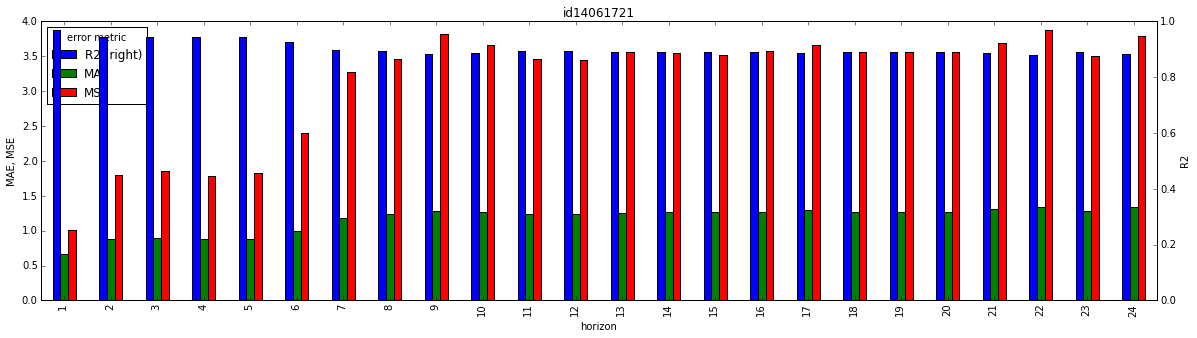

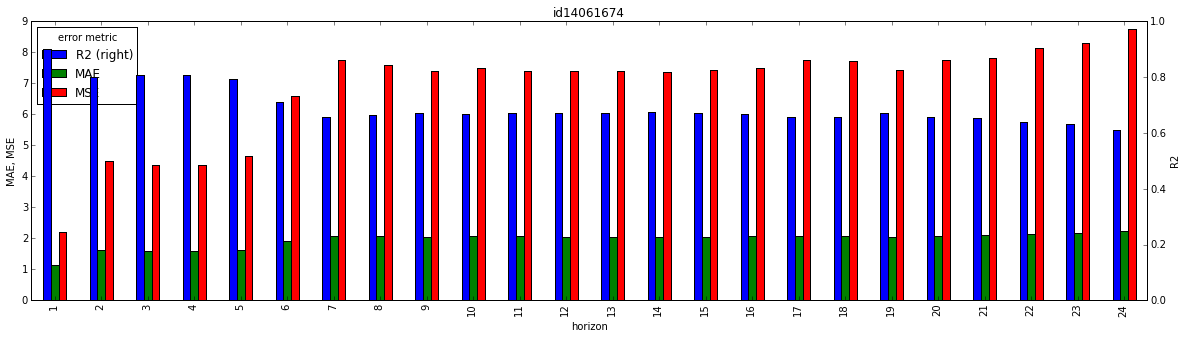

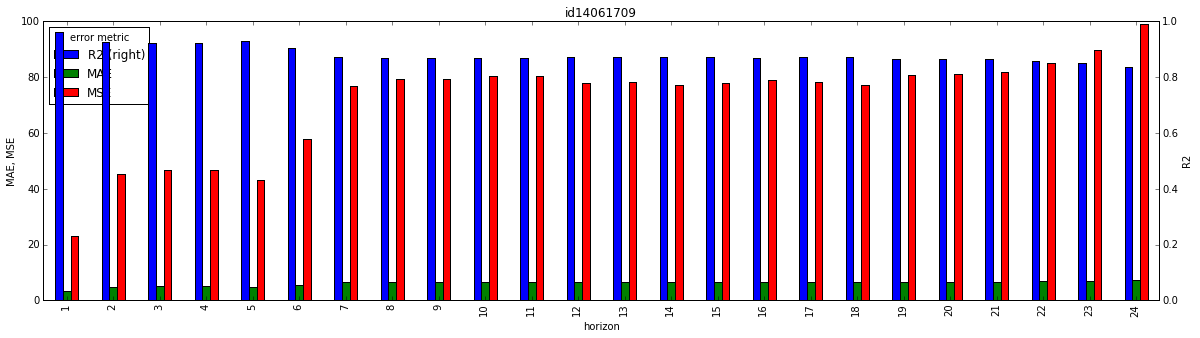

In [264]:
#num_of_graphs = len(validation_df.columns.levels[0])
#f, axx = plt.subplots(num_of_graphs, 1, sharey=True, sharex=True)
#f.set_size_inches(6*num_of_graphs,10)

for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.xs(("top_20_ftrs", "Random Forest"), level=["dataset", "model"])[sensor_id].plot(
        kind='bar', secondary_y=['R2'], title=sensor_id, figsize=(20,5))
    ax.set_ylabel('MAE, MSE')
    ax.right_ax.set_ylabel('R2')

## Averaged Horizons Scores 

In [198]:
validation_df.groupby(level=['dataset', 'model']).mean()

sensor                           id14061721                      id14061674  \
error metric                             R2       MAE        MSE         R2   
dataset      model                                                            
all_ftrs     Ridge Regression      0.700816  2.168537   9.730686   0.694175   
             K Nearest Neighbors  -0.129136  4.262553  36.722203  -0.154634   
             Random Forest         0.898747  1.212764   3.293090   0.685730   
m_wc_wf_ftrs Ridge Regression      0.688844  2.200678  10.120234   0.688672   
             K Nearest Neighbors  -0.086680  4.182131  35.341462  -0.119275   
             Random Forest         0.885892  1.285507   3.711282   0.667609   
m_wc_dt_ftrs Ridge Regression      0.690910  2.179708  10.052759   0.681977   
             K Nearest Neighbors  -0.209127  4.439665  39.324624  -0.191596   
             Random Forest         0.897128  1.201490   3.345705   0.683027   
m_wf_dt_ftrs Ridge Regression      0.678358  2.197123  10.460991   0.679835   
             K Nearest Neighbors   0.642795  2.238961  11.617658   0.217780   
             Random Forest         0.902799  1.168633   3.161275   0.694602   
m_dt_ftrs    Ridge Regression      0.670954  2.220370  10.701683   0.671640   
             K Nearest Neighbors   0.673288  1.966732  10.625538   0.355907   
             Random Forest         0.901761  1.162875   3.195009   0.695289   
m_ftrs       Ridge Regression      0.654646  2.246925  11.232347   0.663058   
             K Nearest Neighbors   0.657928  1.998019  11.125708   0.447856   
             Random Forest         0.828708  1.454929   5.571245   0.630582   
top_20_ftrs  Ridge Regression      0.681551  2.204910  10.357190   0.686964   
             K Nearest Neighbors   0.738608  1.973621   8.501646   0.429445   
             Random Forest         0.903659  1.170715   3.133325   0.695835   

sensor                                                id14061709             \
error metric                           MAE        MSE         R2        MAE   
dataset      model                                                            
all_ftrs     Ridge Regression     1.993369   6.922569   0.766396   9.237519   
             K Nearest Neighbors  3.905317  26.141036   0.170260  16.918270   
             Random Forest        1.989561   7.113628   0.879517   6.377460   
m_wc_wf_ftrs Ridge Regression     2.011455   7.047091   0.724301  10.093765   
             K Nearest Neighbors  3.852228  25.340719   0.187301  16.763125   
             Random Forest        2.042909   7.523743   0.854164   6.998542   
m_wc_dt_ftrs Ridge Regression     2.026879   7.198644   0.760232   9.360916   
             K Nearest Neighbors  3.954889  26.977245   0.138566  17.388441   
             Random Forest        2.000092   7.174769   0.880372   6.357072   
m_wf_dt_ftrs Ridge Regression     2.037533   7.247145   0.747951   9.514249   
             K Nearest Neighbors  3.059493  17.708715   0.450506  13.366186   
             Random Forest        1.965464   6.912847   0.881214   6.284302   
m_dt_ftrs    Ridge Regression     2.058415   7.432589   0.744845   9.557096   
             K Nearest Neighbors  2.791323  14.580653   0.497281  12.675165   
             Random Forest        1.970460   6.897258   0.882259   6.267891   
m_ftrs       Ridge Regression     2.090813   7.626789   0.645993  11.382105   
             K Nearest Neighbors  2.638924  12.498053   0.536614  12.183381   
             Random Forest        2.161938   8.361626   0.830280   7.401128   
top_20_ftrs  Ridge Regression     2.017938   7.085749   0.755725   9.474533   
             K Nearest Neighbors  2.660395  12.916523   0.697571  10.037078   
             Random Forest        1.963005   6.884923   0.881659   6.276590   

sensor                                        
error metric                             MSE  
dataset      model                            
all_ftrs     Ridge Regression     141.754673  
             K Nea

In [370]:
validation_df.groupby(level=['dataset', 'model']).mean()['id14061721']

error metric                            R2       MAE        MSE
dataset      model                                             
all_ftrs     Ridge Regression     0.700816  2.168537   9.730686
             K Nearest Neighbors -0.129136  4.262553  36.722203
             Random Forest        0.898747  1.212764   3.293090
m_wc_wf_ftrs Ridge Regression     0.688844  2.200678  10.120234
             K Nearest Neighbors -0.086680  4.182131  35.341462
             Random Forest        0.885892  1.285507   3.711282
m_wc_dt_ftrs Ridge Regression     0.690910  2.179708  10.052759
             K Nearest Neighbors -0.209127  4.439665  39.324624
             Random Forest        0.897128  1.201490   3.345705
m_wf_dt_ftrs Ridge Regression     0.678358  2.197123  10.460991
             K Nearest Neighbors  0.642795  2.238961  11.617658
             Random Forest        0.902799  1.168633   3.161275
m_dt_ftrs    Ridge Regression     0.670954  2.220370  10.701683
             K Nearest Neighbors  0.673288  1.966732  10.625538
             Random Forest        0.901761  1.162875   3.195009
m_ftrs       Ridge Regression     0.654646  2.246925  11.232347
             K Nearest Neighbors  0.657928  1.998019  11.125708
             Random Forest        0.828708  1.454929   5.571245
top_20_ftrs  Ridge Regression     0.681551  2.204910  10.357190
             K Nearest Neighbors  0.738608  1.973621   8.501646
             Random Forest        0.903659  1.170715   3.133325

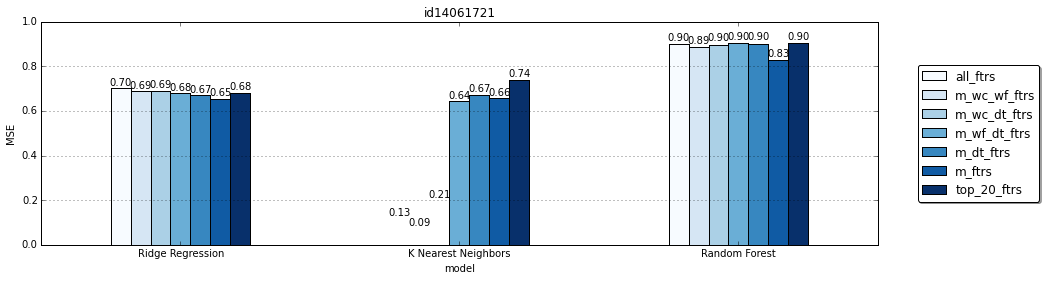

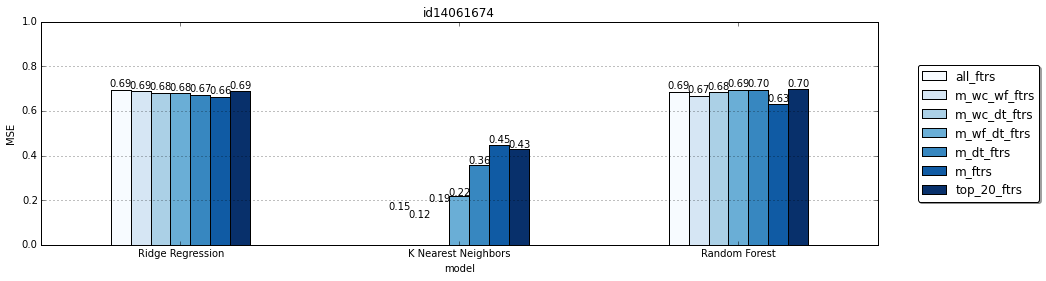

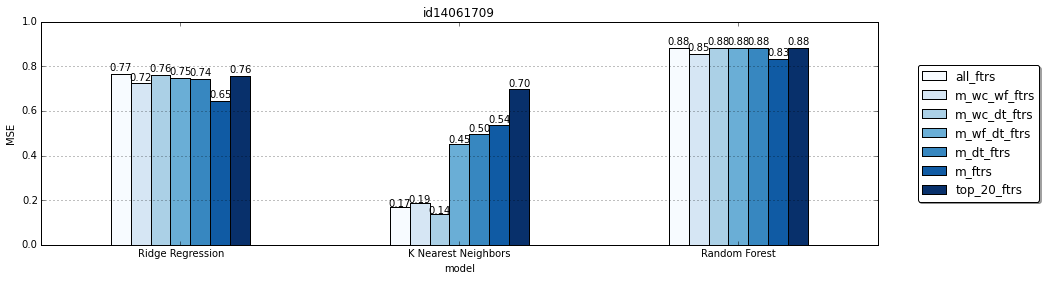

In [376]:
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.groupby(level=['dataset', 'model']).mean()[sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

### Errors only for specific prediction horizon

In [388]:
"""
for sensor_id in validation_df.columns.levels[0]:
    ax = validation_df.loc[20][sensor_id]['R2'].unstack(0).plot(
        kind='bar', figsize=(15,4), rot=0, title=sensor_id, colormap='Blues', ylim=(0,1))
    
    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)
"""

'\nfor sensor_id in validation_df.columns.levels[0]:\n    ax = validation_df.loc[20][sensor_id][\'R2\'].unstack(0).plot(\n        kind=\'bar\', figsize=(15,4), rot=0, title=sensor_id, colormap=\'Blues\', ylim=(0,1))\n    \n    for p in ax.patches:\n        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha=\'center\')\n    \n    plt.gca().yaxis.grid(True)\n    ax.set_ylabel(measure)\n    plt.legend(loc=\'right\', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)\n'

## Averaged Scores by Sensors

In [199]:
validation_df.groupby(level='error metric', axis=1).mean()

error metric                                    R2       MAE         MSE
horizon dataset      model                                              
1       all_ftrs     Ridge Regression     0.944269  1.750940    8.856992
                     K Nearest Neighbors  0.066897  7.988847  177.344176
                     Random Forest        0.943590  1.748790    8.924401
        m_wc_wf_ftrs Ridge Regression     0.944166  1.757183    8.900042
                     K Nearest Neighbors  0.092666  7.919596  175.286799
                     Random Forest        0.943703  1.749920    8.923147
        m_wc_dt_ftrs Ridge Regression     0.944263  1.750683    8.853888
                     K Nearest Neighbors  0.091360  7.845368  171.064147
                     Random Forest        0.943689  1.746819    8.903057
        m_wf_dt_ftrs Ridge Regression     0.944120  1.751837    8.873416
                     K Nearest Neighbors  0.660034  4.426467   52.685557
                     Random Forest        0.944233  1.733138    8.796171
        m_dt_ftrs    Ridge Regression     0.944097  1.751904    8.875414
                     K Nearest Neighbors  0.804704  3.636148   39.212222
                     Random Forest        0.944349  1.730846    8.783673
        m_ftrs       Ridge Regression     0.943962  1.758596    8.922465
                     K Nearest Neighbors  0.872938  3.189027   30.275088
                     Random Forest        0.944133  1.736022    8.826751
        top_20_ftrs  Ridge Regression     0.944205  1.751554    8.861577
                     K Nearest Neighbors  0.776287  3.449343   32.858498
                     Random Forest        0.944374  1.729782    8.771622
2       all_ftrs     Ridge Regression     0.854188  3.063346   26.159467
                     K Nearest Neighbors  0.017433  8.365786  199.677958
                     Random Forest        0.887414  2.526949   17.601357
        m_wc_wf_ftrs Ridge Regression     0.853429  3.088932   26.321493
                     K Nearest Neighbors  0.025562  8.355834  200.024606
                     Random Forest        0.883615  2.544326   17.875777
        m_wc_dt_ftrs Ridge Regression     0.853540  3.060546   26.121296
                     K Nearest Neighbors  0.025626  8.330849  196.201980
                     Random Forest        0.887349  2.529629   17.729855
...                                            ...       ...         ...
23      m_dt_ftrs    Ridge Regression     0.637156  5.244161   70.547558
                     K Nearest Neighbors  0.507144  5.921202  103.638775
                     Random Forest        0.792980  3.574007   34.311882
        m_ftrs       Ridge Regression     0.605835  5.505930   78.981576
                     K Nearest Neighbors  0.529069  5.756699   96.320177
                     Random Forest        0.717986  4.272589   48.652980
        top_20_ftrs  Ridge Regression     0.642693  5.229665   69.153414
                     K Nearest Neighbors  0.559156  5.196304   71.374976
                     Random Forest        0.792090  3.535453   33.895403
24      all_ftrs     Ridge Regression     0.678104  4.744733   58.494166
                     K Nearest Neighbors -0.052645  8.581693  203.928692
                     Random Forest        0.764189  3.730448   38.630922
        m_wc_wf_ftrs Ridge Regression     0.647478  4.932747   63.396458
                     K Nearest Neighbors -0.012461  8.391388  191.624050
                     Random Forest        0.733352  4.165601   46.283397
        m_wc_dt_ftrs Ridge Regression     0.676321  4.756699   58.782008
                     K Nearest Neighbors -0.040585  8.505864  195.459819
                     Random Forest        0.761584  3.735215   38.703490
        m_wf_dt_ftrs Ridge Regression     0.666553  4.771114   60.030892
                     K Nearest Neighbors  0.428109  5.958527   98.381439
                     Random Forest        0.778846  3.606274   36.686329
        m_dt_ftrs    Ridge Regression     0.662670  4.7859

### Error plot for different prediction horizons and averaged errors by sensors

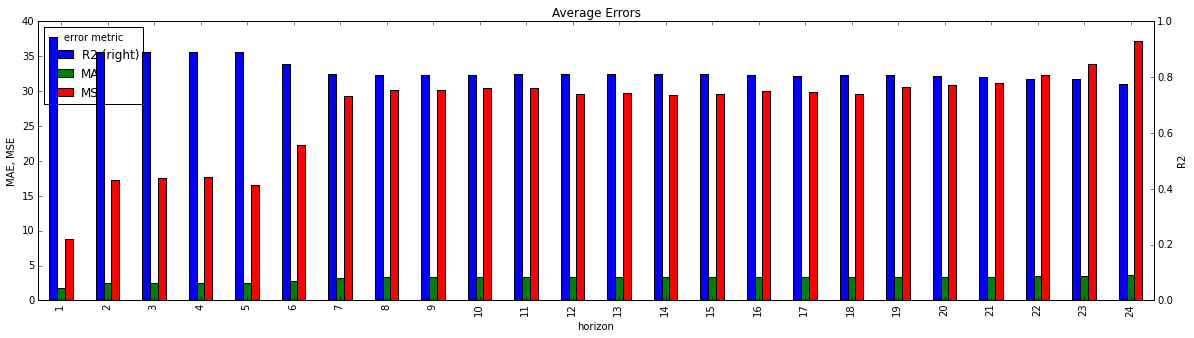

In [261]:
ax = validation_df.xs(("top_20_ftrs", "Random Forest"), level=["dataset", "model"]).groupby(
    level='error metric', axis=1).mean().plot(kind='bar', figsize=(20,5), secondary_y=['R2'], title="Average Errors")
ax.set_ylabel('MAE, MSE')
ax.right_ax.set_ylabel('R2')

## Average Score by Sensors and Horizons

In [200]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean()

error metric                            R2       MAE         MSE
dataset      model                                              
all_ftrs     Ridge Regression     0.720462  4.466475   52.802642
             K Nearest Neighbors -0.037837  8.362046  188.826663
             Random Forest        0.821331  3.193262   27.840997
m_wc_wf_ftrs Ridge Regression     0.700606  4.768633   61.488195
             K Nearest Neighbors -0.006218  8.265828  184.655259
             Random Forest        0.802555  3.442319   33.244426
m_wc_dt_ftrs Ridge Regression     0.711040  4.522501   54.248478
             K Nearest Neighbors -0.087386  8.594331  196.383547
             Random Forest        0.820176  3.186218   27.705966
m_wf_dt_ftrs Ridge Regression     0.702048  4.582968   56.884448
             K Nearest Neighbors  0.437027  6.221547  120.935716
             Random Forest        0.826205  3.139466   27.386925
m_dt_ftrs    Ridge Regression     0.695813  4.611960   57.654655
             K Nearest Neighbors  0.508826  5.811074  110.097256
             Random Forest        0.826436  3.133742   27.181677
m_ftrs       Ridge Regression     0.654566  5.239948   77.890099
             K Nearest Neighbors  0.547466  5.606774  101.611065
             Random Forest        0.763190  3.672665   38.974408
top_20_ftrs  Ridge Regression     0.708080  4.565794   55.223739
             K Nearest Neighbors  0.621875  4.890365   68.318820
             Random Forest        0.827051  3.136770   27.278289

In [270]:
validation_df.groupby(level=['dataset', 'model']).mean().groupby(level='error metric', axis=1).mean().unstack()

error metric               R2                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
all_ftrs             0.720462           -0.037837      0.821331   
m_wc_wf_ftrs         0.700606           -0.006218      0.802555   
m_wc_dt_ftrs         0.711040           -0.087386      0.820176   
m_wf_dt_ftrs         0.702048            0.437027      0.826205   
m_dt_ftrs            0.695813            0.508826      0.826436   
m_ftrs               0.654566            0.547466      0.763190   
top_20_ftrs          0.708080            0.621875      0.827051   

error metric              MAE                                    \
model        Ridge Regression K Nearest Neighbors Random Forest   
dataset                                                           
all_ftrs             4.466475            8.362046      3.193262   
m_wc_wf_ftrs         4.768633            8.265828      3.442319   
m_wc_dt_ftrs         4.522501            8.594331      3.186218   
m_wf_dt_ftrs         4.582968            6.221547      3.139466   
m_dt_ftrs            4.611960            5.811074      3.133742   
m_ftrs               5.239948            5.606774      3.672665   
top_20_ftrs          4.565794            4.890365      3.136770   

error metric              MSE                                    
model        Ridge Regression K Nearest Neighbors Random Forest  
dataset                                                          
all_ftrs            52.802642          188.826663     27.840997  
m_wc_wf_ftrs        61.488195          184.655259     33.244426  
m_wc_dt_ftrs        54.248478          196.383547     27.705966  
m_wf_dt_ftrs        56.884448          120.935716     27.386925  
m_dt_ftrs           57.654655          110.097256     27.181677  
m_ftrs              77.890099          101.611065     38.974408  
top_20_ftrs         55.223739           68.318820     27.278289

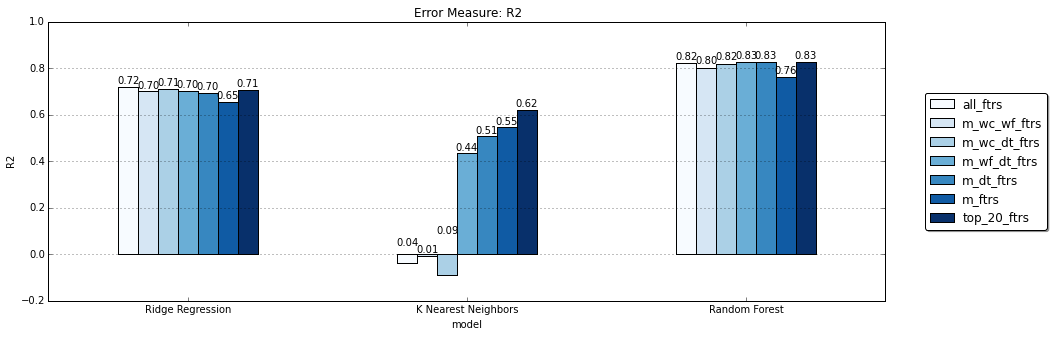

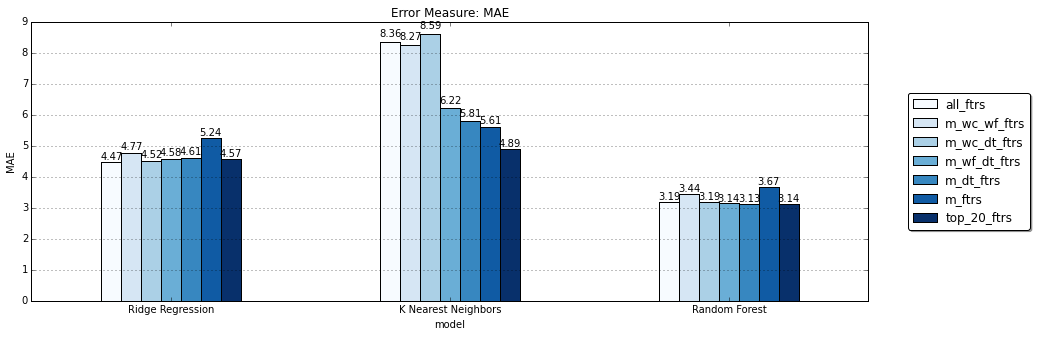

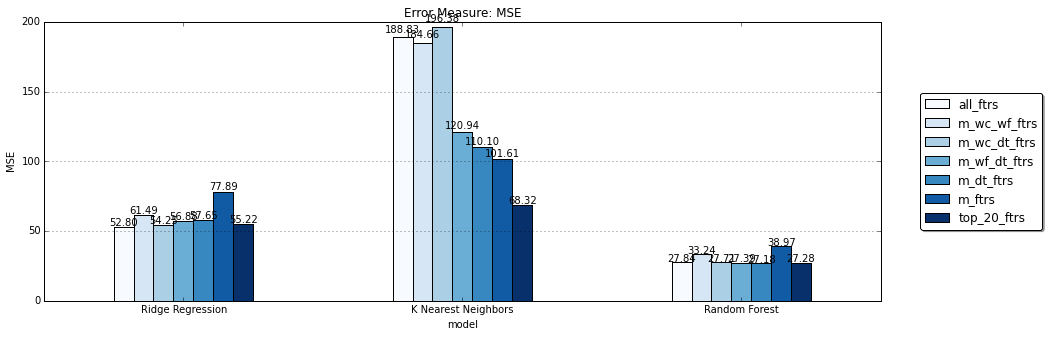

In [353]:
for measure in validation_df.columns.levels[1]:

    ax = validation_df.groupby(level=['dataset', 'model']).mean().groupby(
        level='error metric', axis=1).mean()[measure].unstack(0).plot(
        kind='bar', figsize=(15,5), rot=0, title="Error Measure: {}".format(measure), colormap='Blues')

    for p in ax.patches:
        ax.annotate(str("%.2f" % p.get_height()), (p.get_x()+p.get_width()/2., p.get_height() * 1.02), fontsize=10, ha='center')
    
    plt.gca().yaxis.grid(True)
    ax.set_ylabel(measure)
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.5), ncol=1, fancybox=True, shadow=True)

NOTE: From this, it looks like weather does not help to improve accuracy. Date time features are the most important.